# 규제가 있는 선형회귀 - 릿지, 라쏘, 엘라스틱넷 회귀

#### 규제가 있는 모델 구축 - 당뇨병 데이터세트
#### 1. 데이터 전처리
#### 2. Ridge, Lasso, Elasticnet regression 구축: 회귀 계수 확인, 하이퍼 파라미터 탐색
#### 3. 교차 검증으로 최적의 하이퍼파라미터 탐색: LassoCV()

In [9]:
# 관련 라이브러리 및 모듈 Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# 경고메세지 무시~
import warnings
warnings.filterwarnings(action='ignore')

# 0. 데이터 수집, 탐색, 준비

In [11]:
from sklearn.datasets import load_diabetes

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [12]:
def evaluate_score(y_test,y_pred):
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test,y_pred)

    print(f'mse -{mse:.3f}')
    print(f'rmse-{rmse:.3f}')
    print(f'r2-{r2:.3f}')

    return

####  데이터셋에 대한 설명 및 정보 확인

In [13]:
# 데이터셋 정보확인

In [14]:
diab = load_diabetes()

print(diab)


{'data': array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
         0.01990749, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
        -0.06833155, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
         0.00286131, -0.02593034],
       ...,
       [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
        -0.04688253,  0.01549073],
       [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
         0.04452873, -0.02593034],
       [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
        -0.00422151,  0.00306441]]), 'target': array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
        69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
        68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
        87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
       259.,  53., 190., 142.,  75., 142., 155., 225.,  59., 104., 182.,
  

In [15]:
diab.keys()

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

#### 데이터프레임 변환

In [ ]:
# 독립변수(피처)와 종속변수를 DataFrame자료형으로 변환

In [16]:
# 데이터셋 객체의 data 배열, 즉, 독립변수 X가되는 피처(특성)들을 DataFrame자료형으로 변환하여
# diab_df생성
# diab_df.head() 데이터 5개 확인

diab_df = pd.DataFrame(data=diab.data, columns=diab.feature_names)
diab_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [ ]:
# 누락치 확인,  data type 확인 ->  isnull().sum(), target에 결측값이 있으면 해당 관측치 제거

In [17]:
diab_df.isnull().sum()

age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64

In [18]:
diab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


In [19]:
# X(독립변수), Y(종속변수) 분할
x = diab.data
y= diab.target

In [20]:
# 학습용, 평가용 데이터 분리
# test_size = 0.3 , random_state = 42

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)

# 모델별 계수변화, 알파별 계수 비교 데이터프레임(comp_df)

In [22]:
#각 모델별 계수로 이루어진 데이터프레임 준비
comp_df = pd.DataFrame(index=diab.feature_names +["R2 cores"])
comp_df

""
age
sex
bmi
bp
s1
s2
s3
s4
s5
s6


In [ ]:
#각 모델별, 규제강도별 평가지표 저장


# 1. 규제가 없는 선형모델

In [28]:
#모델 구축 및 학습
model_LR = LinearRegression()

model_LR.fit(x_train, y_train)



r2 = r2_score(y_test, y_pred)

#모델 평가
y_pred = model_LR.predict(x_test)
r2 = r2_score(y_test,y_pred)

# 회귀 계수 확인

LR_coef = pd.Series(model_LR.coef_,index=diab.feature_names)
print(LR_coef)

#r2
print(r2)


age     29.254013
sex   -261.706469
bmi    546.299723
bp     388.398341
s1    -901.959668
s2     506.763241
s3     121.154351
s4     288.035267
s5     659.268951
s6      41.376701
dtype: float64
0.4772897164322617


- 계수값 시각화

s5     659.268951
bmi    546.299723
s2     506.763241
bp     388.398341
s4     288.035267
s3     121.154351
s6      41.376701
age     29.254013
sex   -261.706469
s1    -901.959668
dtype: float64
====
s1     901.959668
s5     659.268951
bmi    546.299723
s2     506.763241
bp     388.398341
s4     288.035267
sex    261.706469
s3     121.154351
s6      41.376701
age     29.254013
dtype: float64


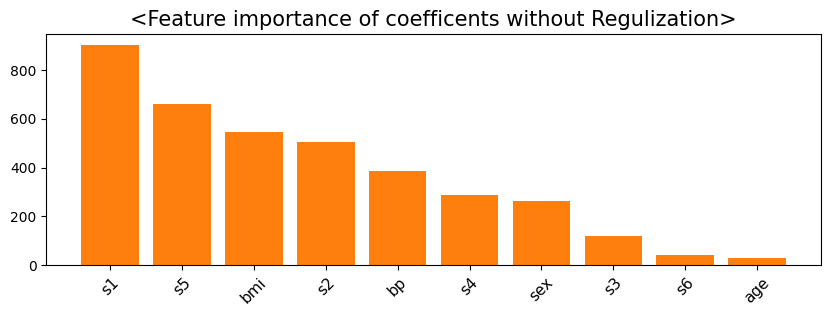

In [42]:
coef = LR_coef.sort_values(ascending=False)
print(coef)
coef = np.abs(LR_coef).sort_values(ascending=False)
print('====')
print(coef)
# 시각화
plt.figure(figsize=(10,3))
plt.bar(coef.index,coef.values)
plt.title("<Feature importance of coefficents without Regulization>",
          fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index,rotation=45,fontsize=11);


In [44]:
# 모델별 비교 데이터프레임 열 추가
comp_df["LR"] = np.append(model_LR.coef_, r2)
comp_df

,LR
age,29.254013
sex,-261.706469
bmi,546.299723
bp,388.398341
s1,-901.959668
s2,506.763241
s3,121.154351
s4,288.035267
s5,659.268951
s6,41.376701


# 1. 릿지 모델

In [47]:
from sklearn.linear_model import Ridge

model_ridge = Ridge()


model_ridge = Ridge(alpha=1)
model_ridge.fit(x_train,y_train)

Ridge(alpha=1)

In [57]:
# 릿지 선형회귀 모델 평가: model_Ridge1, alpha=1

y_pred = model_ridge.predict(x_test)
r2 = r2_score(y_test,y_pred)
# a=1일때 회귀 계수 확인

coef = pd.Series(model_ridge.coef_,index=diab.feature_names)
coef

age     45.054210
sex    -71.947397
bmi    280.716252
bp     195.212662
s1      -2.229303
s2     -17.540797
s3    -148.688862
s4     120.467240
s5     198.614401
s6     106.934692
dtype: float64

In [ ]:
# 선형 모델 평가


#a = 1 릿지 모델 회귀 계수


- 계수값 시각화

In [63]:
pd.Series(np.abs(model_ridge.coef_), index=diab.feature_names)

age     45.054210
sex     71.947397
bmi    280.716252
bp     195.212662
s1       2.229303
s2      17.540797
s3     148.688862
s4     120.467240
s5     198.614401
s6     106.934692
dtype: float64

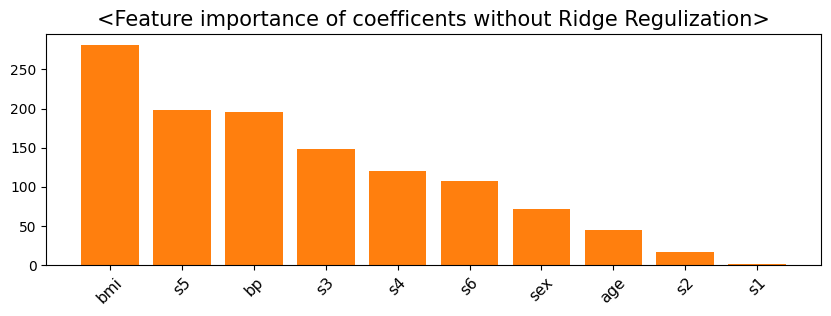

In [54]:
coef = pd.Series(np.abs(model_ridge.coef_),index=diab.feature_names)
coef = coef.sort_values(ascending=False)
# 시각화
plt.figure(figsize=(10, 3))
plt.bar(coef.index, coef.values)
plt.title("<Feature importance of coefficents without Ridge Regulization>",
          fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation=45, fontsize=11);


In [67]:
# alpha_list=[0.01, 1, 10, 100]인 경우

alpha_list = [0.01,1,10,100]

for each in alpha_list:
    model_ridge = Ridge(alpha=each)
    model_ridge.fit(x_train,y_train)

    y_pred = model_ridge.predict(x_test)
    r2 = r2_score(y_test,y_pred)
    col_name = f'Ridge(alpha={each:.2f})'
    comp_df[col_name] = np.append(model_ridge.coef_,r2)

In [68]:
comp_df

,LR,Ridge(alpha=0.01),Ridge(alpha=1.00),Ridge(alpha=10.00),Ridge(alpha=100.00)
age,29.254013,34.167328,45.054210,16.230889,2.072848
sex,-261.706469,-254.043316,-71.947397,-2.961367,-0.003808
bmi,546.299723,550.844882,280.716252,59.524160,6.899915
bp,388.398341,379.126708,195.212662,43.421300,5.085100
s1,-901.959668,-404.253263,-2.229303,13.875073,2.069660
s2,506.763241,123.029219,-17.540797,10.865267,1.743748
s3,121.154351,-99.041674,-148.688862,-37.495847,-4.508876
s4,288.035267,215.032624,120.467240,38.728538,4.902421
s5,659.268951,463.842634,198.614401,49.224746,5.926496
s6,41.376701,50.351490,106.934692,34.737987,4.328698


# 2. 라쏘 모델

In [70]:
from sklearn.linear_model import Lasso

# alpha = 1
model_lasso = Lasso(alpha=1)
model_lasso.fit(x_train,y_train)

Lasso(alpha=1)

In [75]:
# 라쏘 선형회귀 모델 평가(alpha=1)
# 선형 모델 평가
y_pred = model_lasso.predict(x_test)
r2 = r2_score(y_test,y_pred)
print(r2)
#a = 1 라쏘 모델 회귀 계수
lasso_coef = pd.Series(model_lasso.coef_,index=diab.feature_names)
lasso_coef

0.36189802861957876


age      0.000000
sex     -0.000000
bmi    443.703388
bp      51.601094
s1       0.000000
s2       0.000000
s3      -0.000000
s4       0.000000
s5     201.966478
s6       0.000000
dtype: float64

- 계수 시각화

bmi    443.703388
s5     201.966478
bp      51.601094
age      0.000000
sex      0.000000
s1       0.000000
s2       0.000000
s3       0.000000
s4       0.000000
s6       0.000000
dtype: float64


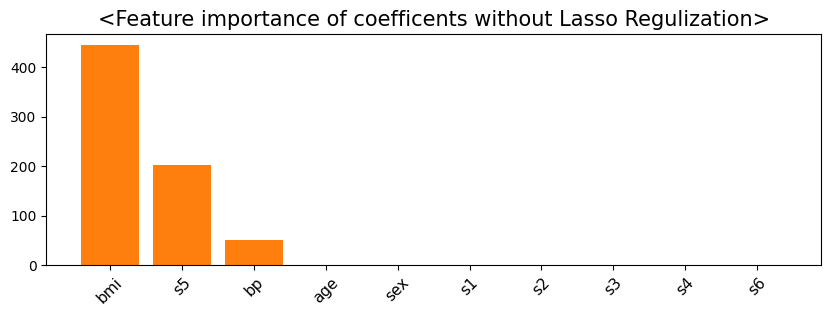

In [81]:
coef = np.abs(lasso_coef)
coef = pd.Series(coef,index=diab.feature_names).sort_values(ascending=False)
print(coef)
# 시각화
plt.figure(figsize=(10, 3))
plt.bar(coef.index, coef.values)
plt.title("<Feature importance of coefficents without Lasso Regulization>",
          fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation=45, fontsize=11);


In [79]:
# alpha_list=[0.01, 1, 10, 100]인 경우
alpha_list = [0.01, 1, 10, 100]

for each in alpha_list:
    model_lasso = Ridge(alpha=each)
    model_lasso.fit(x_train, y_train)
    
    y_pred = model_lasso.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    col_name = f'Ridge(alpha={each:.2f})'
    
    comp_df[col_name] = np.append(model_lasso.coef_, r2)

In [82]:
comp_df

,LR,Ridge(alpha=0.01),Ridge(alpha=1.00),Ridge(alpha=10.00),Ridge(alpha=100.00)
age,29.254013,34.167328,45.054210,16.230889,2.072848
sex,-261.706469,-254.043316,-71.947397,-2.961367,-0.003808
bmi,546.299723,550.844882,280.716252,59.524160,6.899915
bp,388.398341,379.126708,195.212662,43.421300,5.085100
s1,-901.959668,-404.253263,-2.229303,13.875073,2.069660
s2,506.763241,123.029219,-17.540797,10.865267,1.743748
s3,121.154351,-99.041674,-148.688862,-37.495847,-4.508876
s4,288.035267,215.032624,120.467240,38.728538,4.902421
s5,659.268951,463.842634,198.614401,49.224746,5.926496
s6,41.376701,50.351490,106.934692,34.737987,4.328698


# 3. 엘라스틱넷 모델

In [105]:
from sklearn.linear_model import ElasticNet
# 모델 구축 및 학습(alpha=1, l1_ratio=0.5)

model_elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)
model_elasticnet.fit(x_train,y_train)

ElasticNet(alpha=0.1)

In [106]:
#모델 평가 및 회귀 계수 확인
# 엘라스틱넷 선형회귀 모델 평가(alpha=1, L1_ratio=0.5)
# 선형 모델 평가

y_pred = model_elasticnet.predict(x_test)
r2 = r2_score(y_test,y_pred)
print("r2:",r2)


#a = 1 엘라스틱넷 모델 회귀 계수
elasticnet_coef = pd.Series(model_elasticnet.coef_, index=diab.feature_names)
elasticnet_coef

r2: 0.10409724421868916


age    10.591712
sex    -0.285015
bmi    39.807218
bp     28.892278
s1      9.604595
s2      7.589472
s3    -25.067309
s4     26.506264
s5     33.260185
s6     23.526244
dtype: float64

- 계수 시각화

bmi    39.807218
s5     33.260185
bp     28.892278
s4     26.506264
s3     25.067309
s6     23.526244
age    10.591712
s1      9.604595
s2      7.589472
sex     0.285015
dtype: float64


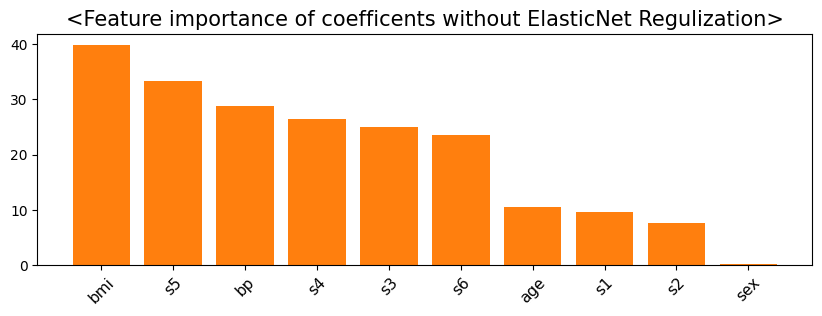

In [107]:
coef = np.abs(elasticnet_coef)
coef = pd.Series(coef,index=diab.feature_names).sort_values(ascending=False)
print(coef)
# 시각화
plt.figure(figsize=(10, 3))
plt.bar(coef.index, coef.values)
plt.title("<Feature importance of coefficents without ElasticNet Regulization>",
          fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation=45, fontsize=11);



In [116]:
# alpha_list=[0.01, 1, 10, 100]인 경우, l1_ratio=0.5
alpha_list=[0.01, 1, 10, 100]

for each in alpha_list:
    model_ElasticNet = ElasticNet(alpha=each)
    model_ElasticNet.fit(x_train, y_train)
    y_pred = model_ElasticNet.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    col_name = f'ElasticNet(alpha={each:.2f})'
    comp_df[col_name] = np.append(model_ElasticNet.coef_, r2)

In [117]:
comp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, age to R2 cores
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   LR                        11 non-null     float64
 1   Ridge(alpha=0.01)         11 non-null     float64
 2   Ridge(alpha=1.00)         11 non-null     float64
 3   Ridge(alpha=10.00)        11 non-null     float64
 4   Ridge(alpha=100.00)       11 non-null     float64
 5   ElasticNet(alpha=0.01)    11 non-null     float64
 6   ElasticNet(alpha=1.00)    11 non-null     float64
 7   ElasticNet(alpha=10.00)   11 non-null     float64
 8   ElasticNet(alpha=100.00)  11 non-null     float64
dtypes: float64(9)
memory usage: 880.0+ bytes


### LassoCV() : k-폴드 교차 검증으로 최적의 Lasso 모델 하이퍼파라미터 alpha 찾기

In [110]:
#LassoCV()에 필요한 매개변수 설정
#0.01 ~ 9.91 까지 alpha_list  생성

cv = 5
alpha_list = np.arange(0.01,10,0.01)
max_iter = 1000


In [112]:
from sklearn.linear_model import LassoCV

model_LassoCV = LassoCV(alphas=alpha_list,cv=5,max_iter=100,n_jobs=-1,
        random_state=42)

- 모델 학습

In [113]:
model_LassoCV.fit(x_train,y_train)

LassoCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67...
       9.36, 9.37, 9.38, 9.39, 9.4 , 9.41, 9.42, 9.43, 9.44, 9.45, 9.46,
       9.47, 9.48, 9.49, 9.5 , 9.51, 9.52, 9.53, 9.54, 9.55, 9.56, 9.57,
       9.58, 9.59, 9.6 , 9.61, 9.62, 9.63, 9.64, 9.65, 9.66, 9.67, 9.68,
       9.69, 9.7 , 9.71, 9.72, 9.73, 9.74, 9.75, 9.76, 9.77, 9.78, 9.79,
       9.8 , 9.81, 9.82, 9.83, 9.84, 9.85, 9.86, 9.87, 9.88, 9.89, 9.9 ,
       9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99]),
        cv=5, max_iter=100, n_jobs=-1, random_state=42)

In [114]:
model_LassoCV.alpha_

0.01

In [118]:
# 다시 학습하는 옵션
y_pred = model_LassoCV.predict(x_test)
r2_score(y_test,y_pred)

0.47859616171526775

## GridSerachCV

In [121]:
from sklearn.model_selection import GridSearchCV

model = ElasticNet()
param_gird = {
    'alpha' : [0.01,1,10,100],
    'l1_ratio' : [0.1,0.3,0.6,0.9]
}


grid = GridSearchCV(model,param_grid=param_gird,cv = 3)

In [122]:
grid.fit(x_train,y_train)

GridSearchCV(cv=3, estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 1, 10, 100],
                         'l1_ratio': [0.1, 0.3, 0.6, 0.9]})

In [123]:
y_pred = grid.predict(x_test)
r2 =r2_score(y_test,y_pred)
print(r2)

0.47378958651114567


In [124]:
grid.best_params_

{'alpha': 0.01, 'l1_ratio': 0.9}

In [128]:
pd.DataFrame(grid.cv_results_)[['mean_test_score','rank_test_score']]

,mean_test_score,rank_test_score
0,0.276728,4
1,0.308736,3
2,0.371355,2
3,0.454411,1
4,-0.028251,8
5,-0.027520,7
6,-0.024958,6
7,-0.007083,5
8,-0.034742,9
9,-0.035039,10


## [응용] 보스턴 주택가격 데이터를 활용하여, 규제가 없을때, 리지, 라쏘, 엘라스틱넷 선형회귀를 수행하고 각각의 회귀계수 및 예측 성능을 비교하라
테스트 사이즈:0.3
random_state=42
